In [3]:
#!pip install plotly

In [4]:
import numpy as np
import plotly
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Section 1 Data Preparation

In [5]:
df = pd.read_csv("res_purchase_card_(pcard)_fiscal_year_2014_3pcd-aiuu.csv")

In [6]:
df.describe()

,Year-Month,Agency Number,Amount
count,442458.000000,442458.000000,4.424580e+05
mean,201357.284375,42785.860353,4.249912e+02
std,47.107417,33378.461293,5.266509e+03
min,201307.000000,1000.000000,-4.286304e+04
25%,201309.000000,1000.000000,3.091000e+01
50%,201401.000000,47700.000000,1.048900e+02
75%,201404.000000,76000.000000,3.450000e+02
max,201406.000000,98000.000000,1.903858e+06


###  1.1 Create date fields

In [7]:
#converting transaction date and posted date to datetime[64] 
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['Posted Date']=pd.to_datetime(df['Posted Date'])

In [8]:
#converting year-month attribute to datetime[64]
df['Year-Month'].dtype
df['Year-Month']=pd.to_datetime(df['Year-Month'], format='%Y%m')

In [9]:
# extract year and month from year-month to create 2 new columns
df['Year'] = df['Year-Month'].dt.year
df['Month'] = df['Year-Month'].dt.month

In [10]:
# create a column named week_number denoting week number
df['Week_Number'] = df['Transaction Date'].dt.isocalendar().week

In [11]:
# create column named day_of_week denoting the day of week
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['Day_of_Week'] = df['Transaction Date'].dt.dayofweek.map(dayOfWeek)

In [12]:
df['Day_of_Week'].value_counts()

Wednesday    89644
Thursday     87537
Tuesday      86919
Friday       79917
Monday       61809
Saturday     26307
Sunday       10325
Name: Day_of_Week, dtype: int64

## Section 2 Initial observations 

<AxesSubplot:xlabel='Count', ylabel='Agency Name'>

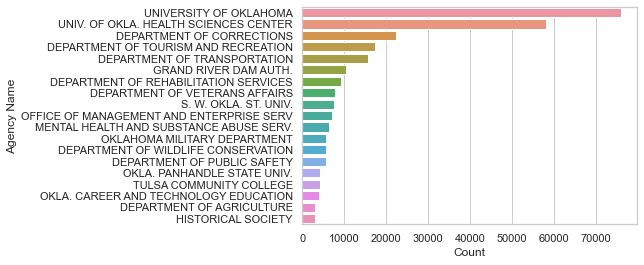

In [13]:
df_count = df['Agency Name'].value_counts()
df_count = pd.DataFrame(df_count).reset_index()
df_count.columns = ['Agency Name','Count']

fig = px.bar(df_count, x='Agency Name', y='Count', color = 'Agency Name', width=1000, height=400)
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.barplot(y="Agency Name", x="Count", data=df_count[1:20])

## Section 3 Feature Engineering
###  3.1 Feature 1: The ratio to average amount

In [14]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency Name', 'Merchant Category Code (MCC)'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['AVG_amount']
stat_by_agency

AVG_amount
Agency Name                     Merchant Category Code (MCC)                          
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED  115.120000
                                CATALOG MERCHANTS                           -53.344286
                                COMPUTER NETWORK/INFORMATION SERVICES        18.340000
                                DRUG STORES AND PHARMACIES                  153.450000
                                GROCERY STORES,AND SUPERMARKETS              74.525455
...                                                                                ...
`DEPARTMENT OF EDUCATION        TELECOMMUNICATION SERVICES                  118.054000
                                TRAVEL AGENCIES                              24.253731
                                TROPICANA RESORT AND CASINO                 481.600000
                                UNITED AIRLINES                             310.547368
                                WYNDHAM HOTELS                               93.282857

[8427 rows x 1 columns]

In [15]:
# add the new feature average spending to the dataset 
df1 = pd.merge(df, stat_by_agency, how='left', on=['Agency Name', 'Merchant Category Code (MCC)'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df1['agency_merchant_avg_ratio_amount'] = np.where(df1['AVG_amount']==0,0, df1['Amount'] / df1['AVG_amount'])
df1['agency_merchant_avg_ratio_amount'].describe()

count    4.424580e+05
mean     9.996757e-01
std      7.547215e+13
min     -2.191001e+16
25%      1.771615e-01
50%      5.153201e-01
75%      1.102916e+00
max      2.191001e+16
Name: agency_merchant_avg_ratio_amount, dtype: float64

In [18]:
# cut by percentile for plotting
var = 'agency_merchant_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df1[binned_var] = pd.qcut( df1[var],percentile)
#df1[['agency_merchant_avg_ratio_amount_D']]

<AxesSubplot:xlabel='agency_merchant_avg_ratio_amount_D', ylabel='count'>

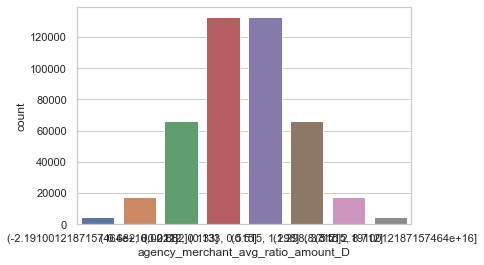

In [19]:
sns.countplot(x="agency_merchant_avg_ratio_amount_D", data=df1)

[Text(0, 0, '(-2.1910012187157464e+16, -0.682]'),
 Text(1, 0, '(-0.682, 0.0212]'),
 Text(2, 0, '(0.0212, 0.133]'),
 Text(3, 0, '(0.133, 0.515]'),
 Text(4, 0, '(0.515, 1.298]'),
 Text(5, 0, '(1.298, 3.515]'),
 Text(6, 0, '(3.515, 8.712]'),
 Text(7, 0, '(8.712, 2.1910012187157464e+16]')]

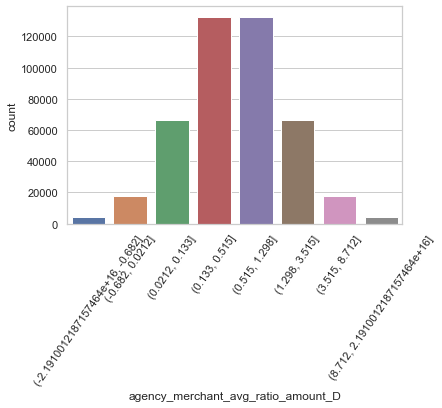

In [20]:
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_avg_ratio_amount_D", data=df1)
g.set_xticklabels(g.get_xticklabels(), rotation=55)

## 3.2 Feature 2: The ratio to the median amount

In [21]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency Name', 'Merchant Category Code (MCC)'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['Median_amount']

In [22]:
# add the new feature average spending to the dataset 
df2 = pd.merge(df1, stat_by_agency, how='left', on=['Agency Name', 'Merchant Category Code (MCC)'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df2['agency_merchant_median_ratio_amount'] = np.where(df2['Median_amount']==0,0, df2['Amount'] / df2['Median_amount'])
df2['agency_merchant_median_ratio_amount'].describe()

count    442458.000000
mean          4.952685
std        1078.581350
min       -1003.176471
25%           0.466090
50%           1.000000
75%           2.121102
max      528116.052705
Name: agency_merchant_median_ratio_amount, dtype: float64

In [23]:
# cut by percentile for plotting
var = 'agency_merchant_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df2[binned_var] = pd.qcut( df2[var],percentile)

[Text(0, 0, '(-1003.177, -1.121]'),
 Text(1, 0, '(-1.121, 0.0653]'),
 Text(2, 0, '(0.0653, 0.362]'),
 Text(3, 0, '(0.362, 1.0]'),
 Text(4, 0, '(1.0, 2.691]'),
 Text(5, 0, '(2.691, 9.283]'),
 Text(6, 0, '(9.283, 28.085]'),
 Text(7, 0, '(28.085, 528116.053]')]

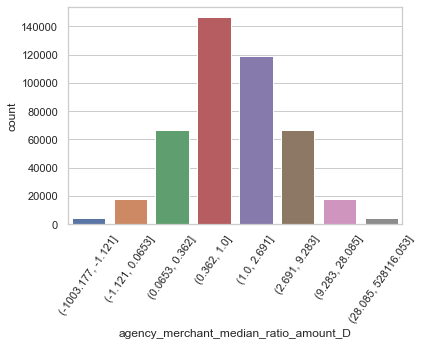

In [24]:
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_median_ratio_amount_D", data=df2)
g.set_xticklabels(g.get_xticklabels(), rotation=55)

In [25]:
df2[df2['agency_merchant_median_ratio_amount']>2].head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,...,Year,Month,Week_Number,Day_of_Week,AVG_amount,agency_merchant_avg_ratio_amount,agency_merchant_avg_ratio_amount_D,Median_amount,agency_merchant_median_ratio_amount,agency_merchant_median_ratio_amount_D
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,...,2013,7,31,Tuesday,427.634060,2.081219,"(1.298, 3.515]",250.000,3.560000,"(2.691, 9.283]"
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,...,2013,7,31,Tuesday,59.832149,1.611007,"(1.298, 3.515]",32.485,2.967216,"(2.691, 9.283]"
5,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.28,KYOCERA DOCUMENT SOLUTION,2013-07-29,2013-07-31,...,2013,7,31,Monday,217.254954,1.814826,"(1.298, 3.515]",181.940,2.167088,"(1.0, 2.691]"
12,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McLemore,A,GENERAL PURCHASE,572.27,GIDDINGS MACHINE CO.,2013-07-30,2013-07-31,...,2013,7,31,Tuesday,436.425953,1.311265,"(1.298, 3.515]",187.000,3.060267,"(2.691, 9.283]"
14,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Meints,K,GENERAL PURCHASE,445.00,OK DEPT OF VO-TECH ED,2013-07-30,2013-07-31,...,2013,7,31,Tuesday,308.598782,1.442002,"(1.298, 3.515]",91.500,4.863388,"(2.691, 9.283]"


creating a function to create bins and charts

In [47]:
def cut_percentiles(variable,df):
    # cut by percentile for plotting
    var = str(variable)
    binned_var = var + '_D'
    percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
    df[binned_var] = pd.qcut(df[var],percentile)

    plt.figure(figsize=(6,4))
    g = sns.countplot(x=binned_var, data=df)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)

## 3.3 Feature 3: The ratio to the average amount grouped by agency, merchant category and month
Grouping by agency, MCC and Month we calculate the average amount spent. This helps understand the monthly expenditure for a person in an agency per merchant category.

In [26]:
# create average spending group by agency, merchant category and month
stat_by_agency = df.groupby(['Agency Name', 'Merchant Category Code (MCC)','Month'])['Amount'].mean() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['agency_name_mcc_month_avg_amount']

In [27]:
# add the new feature average spending to the dataset 
df3 = pd.merge(df2, stat_by_agency, how='left', on=['Agency Name', 'Merchant Category Code (MCC)','Month'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df3['agency_name_mcc_month_mean_ratio_amount'] = np.where(df3['agency_name_mcc_month_avg_amount']==0,0, df3['Amount'] / df3['agency_name_mcc_month_avg_amount'])
df3['agency_name_mcc_month_mean_ratio_amount'].describe()

count    4.424580e+05
mean     9.990183e-01
std      1.781013e+14
min     -3.900927e+16
25%      2.017872e-01
50%      5.985407e-01
75%      1.125320e+00
max      5.267839e+16
Name: agency_name_mcc_month_mean_ratio_amount, dtype: float64

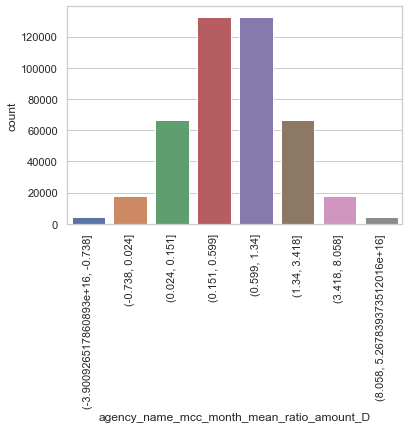

In [54]:
cut_percentiles('agency_name_mcc_month_mean_ratio_amount',df3)

## 3.4 Feature 4: The ratio to the median amount grouped by agency, merchant category and month
Grouping by agency, MCC and Month we calculate the average amount spent. This helps understand the monthly expenditure for a person in an agency per merchant category.

In [55]:
# create average spending group by agency, merchant category and month
stat_by_agency = df.groupby(['Agency Name', 'Merchant Category Code (MCC)','Month'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['agency_name_mcc_month_median_amount']

In [56]:
# add the new feature average spending to the dataset 
df3 = pd.merge(df3, stat_by_agency, how='left', on=['Agency Name', 'Merchant Category Code (MCC)','Month'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df3['agency_name_mcc_month_median_amount_ratio'] = np.where(df3['agency_name_mcc_month_median_amount']==0,0, df3['Amount'] / df3['agency_name_mcc_month_median_amount'])
df3['agency_name_mcc_month_median_amount_ratio'].describe()

count    442458.000000
mean          5.010047
std        1195.766096
min      -29642.000000
25%           0.500000
50%           1.000000
75%           1.912717
max      598420.505983
Name: agency_name_mcc_month_median_amount_ratio, dtype: float64

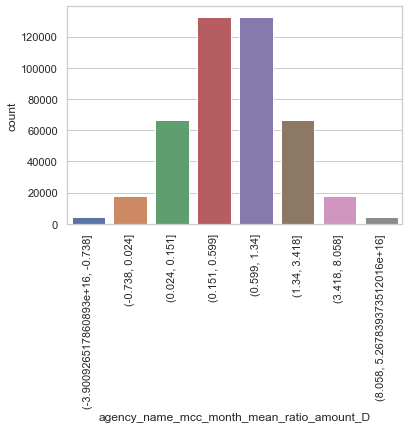

In [57]:
cut_percentiles('agency_name_mcc_month_mean_ratio_amount',df3)

## 3.5 Feature 5: The ratio to the average amount grouped by year and month per person

Grouping by Year, Month and Person we calculate the average amount spent. This helps understand the average monthly expenditure in year per person

In [61]:
# create average spending group by year and month per person
stat_by_agency = df.groupby(['Year', 'Month','Cardholder Last Name'])['Amount'].mean() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['mean_expense_person_person']

In [62]:
# add the new feature average spending to the dataset 
df3 = pd.merge(df3, stat_by_agency, how='left', on=['Year', 'Month','Cardholder Last Name'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df3['monthly_avg_person_ratio_amount'] = np.where(df3['mean_expense_person_person']==0,0, df3['Amount'] / df3['mean_expense_person_person'])
df3['monthly_avg_person_ratio_amount'].describe()

count    4.424580e+05
mean     9.996490e-01
std      1.578997e+14
min     -7.151575e+16
25%      1.462510e-01
50%      4.953139e-01
75%      1.271078e+00
max      6.403556e+16
Name: monthly_avg_person_ratio_amount, dtype: float64

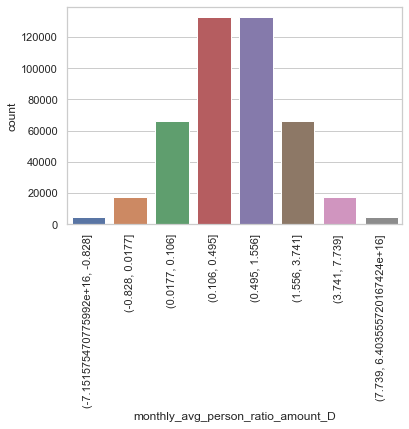

In [63]:
cut_percentiles('monthly_avg_person_ratio_amount',df3)

## 3.6 Feature 6: The ratio to the median amount grouped by year and month per person

Grouping by Year, Month and Person we calculate the median amount spent. This helps understand the average monthly expenditure in year per person

In [64]:
# create average spending group by year and month per person
stat_by_agency = df.groupby(['Year', 'Month','Cardholder Last Name'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['median_expense_person_person']

# add the new feature average spending to the dataset 
df3 = pd.merge(df3, stat_by_agency, how='left', on=['Year', 'Month','Cardholder Last Name'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df3['monthly_median_person_ratio_amount'] = np.where(df3['median_expense_person_person']==0,0, df3['Amount'] / df3['median_expense_person_person'])
df3['monthly_median_person_ratio_amount'].describe()

count    442458.000000
mean          2.773682
std          85.479848
min      -49090.000000
25%           0.401202
50%           1.000000
75%           2.343775
max        6000.000000
Name: monthly_median_person_ratio_amount, dtype: float64

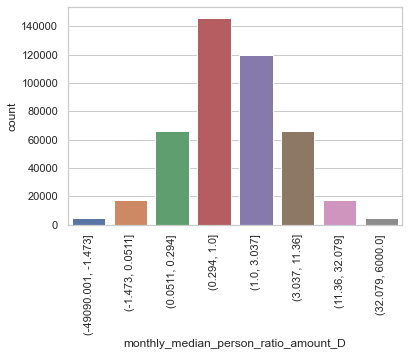

In [65]:
cut_percentiles('monthly_median_person_ratio_amount',df3)

## 3.7 Feature 7: The ratio to the average amount grouped by Cardholder Last Name and Merchant Category Code (MCC)

Grouping by Cardholder Last Name and merchant category code and obtaining the average amount spent by a person in a merchant category. It helps form a pattern and identify outliers. 

In [66]:
# create average spending group by Cardholder Last Name and Merchant Category Code (MCC)
stat_by_agency = df.groupby(['Cardholder Last Name','Merchant Category Code (MCC)'])['Amount'].mean() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['mean_mcc_person']

df3 = pd.merge(df3, stat_by_agency, how='left', on=['Cardholder Last Name','Merchant Category Code (MCC)'])
# Feature 5: ratio of amount spending and avergae spending by merchant category 
df3['mean_mcc_person_ratio_amount'] = np.where(df3['mean_mcc_person']==0,0, df3['Amount'] / df5['mean_mcc_person'])
df3['mean_mcc_person_ratio_amount'].describe()

count    4.424580e+05
mean     9.965958e-01
std      4.338485e+14
min     -7.151575e+16
25%      3.305758e-01
50%      8.044115e-01
75%      1.202406e+00
max      1.014323e+17
Name: mean_mcc_person_ratio_amount, dtype: float64

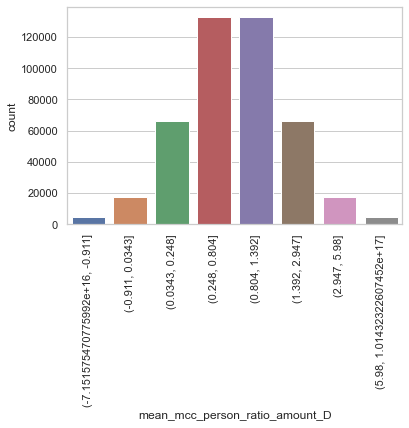

In [67]:
cut_percentiles('mean_mcc_person_ratio_amount',df3)

## 3.8 Feature 8: The ratio to the median amount grouped by Cardholder Last Name and Merchant Category Code (MCC)

Grouping by Cardholder Last Name and merchant category code and obtaining the median amount spent by a person in a merchant category. It helps form a pattern and identify outliers. 

In [71]:
# create average spending group by Cardholder Last Name and Merchant Category Code (MCC)
stat_by_agency = df.groupby(['Cardholder Last Name','Merchant Category Code (MCC)'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['median_mcc_person']

In [73]:
df3 = pd.merge(df3, stat_by_agency, how='left', on=['Cardholder Last Name','Merchant Category Code (MCC)'])
# Feature 5: ratio of amount spending and avergae spending by merchant category 
df3['median_mcc_person_ratio_amount'] = np.where(df3['median_mcc_person']==0,0, df3['Amount'] / df3['median_mcc_person'])
df3['median_mcc_person_ratio_amount'].describe()

count    4.424580e+05
mean     1.051513e+02
std      4.860020e+04
min     -8.195918e+02
25%      6.056647e-01
50%      1.000000e+00
75%      1.540674e+00
max      2.379823e+07
Name: median_mcc_person_ratio_amount, dtype: float64

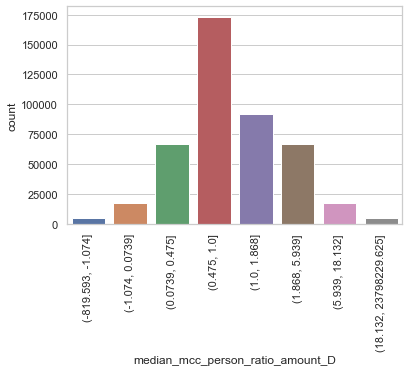

In [74]:
cut_percentiles('median_mcc_person_ratio_amount',df3)

## 3.9 Feature 9: The ratio to average amount per vendor
Grouping by average amo and obtaining the averge amount spent by a person in a merchant category. It helps form a pattern and identify outliers. 

In [77]:
# create average spending group by Cardholder Last Name and Merchant Category Code (MCC)
stat_by_agency = df.groupby(['Agency Name', 'Vendor'])['Amount'].mean() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['mean_agency_vendor']

df3 = pd.merge(df3, stat_by_agency, how='left', on=['Agency Name', 'Vendor'])
# Feature 5: ratio of amount spending and avergae spending by merchant category 
df3['mean_agency_vendor_ratio'] = np.where(df3['mean_agency_vendor']==0,0, df3['Amount'] / df3['mean_agency_vendor'])
df3['mean_agency_vendor_ratio'].describe()

count    4.424580e+05
mean     9.929604e-01
std      2.571723e+14
min     -6.944551e+16
25%      3.399514e-01
50%      9.543501e-01
75%      1.040772e+00
max      6.424385e+16
Name: mean_agency_vendor_ratio, dtype: float64

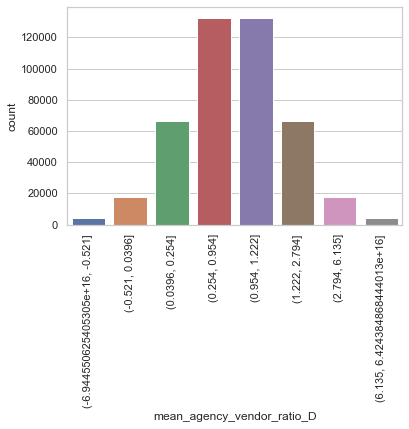

In [78]:
cut_percentiles('mean_agency_vendor_ratio',df3)

## 3.10 Feature 10: The ratio to median amount per vendor
Grouping by Agency and vendor and obtaining the median amount spent by a person in a merchant category. It helps form a pattern and identify outliers. 

In [80]:
# create average spending group by Cardholder Last Name and Merchant Category Code (MCC)
stat_by_agency = df.groupby(['Agency Name', 'Vendor'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['median_agency_vendor']

df3 = pd.merge(df3, stat_by_agency, how='left', on=['Agency Name', 'Vendor'])
# Feature 5: ratio of amount spending and avergae spending by merchant category 
df3['median_agency_vendor_ratio'] = np.where(df3['median_agency_vendor']==0,0, df3['Amount'] / df3['median_agency_vendor'])
df3['median_agency_vendor_ratio'].describe()

count    442458.000000
mean          1.829670
std          21.214313
min        -683.920000
25%           0.658277
50%           1.000000
75%           1.446572
max       13119.000000
Name: median_agency_vendor_ratio, dtype: float64

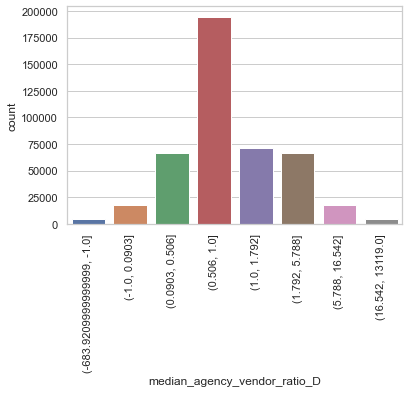

In [81]:
cut_percentiles('median_agency_vendor_ratio',df3)

## 3.11 Feature 11: The ratio to average amount per month per vendor
Just as described for the merchant category features, I will now include a time perspective to the variable to adjust for time sensitive factors.

In [82]:
# create average spending group by Cardholder Last Name and Merchant Category Code (MCC)
stat_by_agency = df.groupby(['Agency Name', 'Vendor','Month'])['Amount'].mean() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['mean_agency_vendor_month']

df3 = pd.merge(df3, stat_by_agency, how='left', on=['Agency Name', 'Vendor','Month'])
# Feature 5: ratio of amount spending and avergae spending by merchant category 
df3['mean_agency_vendor_month_ratio'] = np.where(df3['mean_agency_vendor_month']==0,0, df3['Amount'] / df3['mean_agency_vendor_month'])
df3['mean_agency_vendor_month_ratio'].describe()

count    4.424580e+05
mean     9.940944e-01
std      4.174233e+14
min     -1.266826e+17
25%      4.631081e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.263193e+17
Name: mean_agency_vendor_month_ratio, dtype: float64

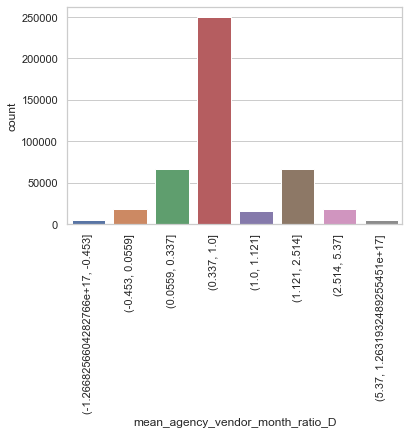

In [83]:
cut_percentiles('mean_agency_vendor_month_ratio',df3)

## 3.12 Feature 12: The ratio to median amount per month per vendor
Just as described for the merchant category features, I will now include a time perspective to the variable to adjust for time sensitive factors.

In [84]:
# create average spending group by Cardholder Last Name and Merchant Category Code (MCC)
stat_by_agency = df.groupby(['Agency Name', 'Vendor','Month'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['median_agency_vendor_month']

df3 = pd.merge(df3, stat_by_agency, how='left', on=['Agency Name', 'Vendor','Month'])
# Feature 5: ratio of amount spending and avergae spending by merchant category 
df3['median_agency_vendor_month_ratio'] = np.where(df3['median_agency_vendor_month']==0,0, df3['Amount'] / df3['median_agency_vendor_month'])
df3['median_agency_vendor_month_ratio'].describe()

count    442458.000000
mean          1.798033
std          98.046931
min       -2087.333333
25%           0.822357
50%           1.000000
75%           1.166989
max       63226.000000
Name: median_agency_vendor_month_ratio, dtype: float64

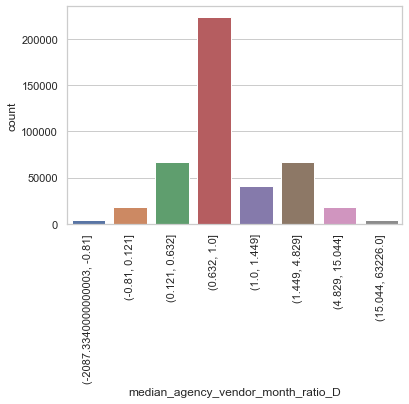

In [85]:
cut_percentiles('median_agency_vendor_month_ratio',df3)

## 3.13 Feature 13: The ratio to average amount per description

In [88]:
# create average spending group by Cardholder Last Name and Merchant Category Code (MCC)
stat_by_agency = df.groupby(['Agency Name', 'Description'])['Amount'].mean() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['mean_agency_desc']

df3 = pd.merge(df3, stat_by_agency, how='left', on=['Agency Name', 'Description'])
# Feature 5: ratio of amount spending and avergae spending by merchant category 
df3['mean_agency_desc_ratio'] = np.where(df3['mean_agency_desc']==0,0, df3['Amount'] / df3['mean_agency_desc'])
df3['mean_agency_desc_ratio'].describe()

count    4.424580e+05
mean     9.986865e-01
std      2.012543e+14
min     -6.275203e+16
25%      1.612777e-01
50%      7.449663e-01
75%      1.000000e+00
max      6.275203e+16
Name: mean_agency_desc_ratio, dtype: float64

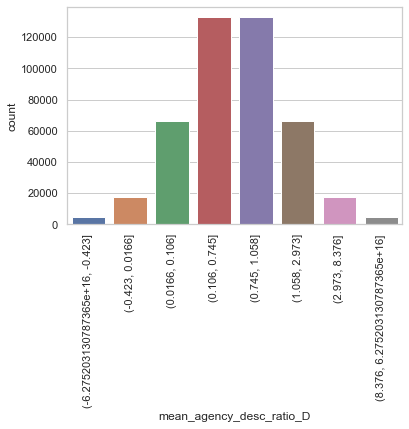

In [89]:
cut_percentiles('mean_agency_desc_ratio',df3)

## 3.14 Feature 14: The ratio to median amount per description

In [90]:
# create average spending group by Cardholder Last Name and Merchant Category Code (MCC)
stat_by_agency = df.groupby(['Agency Name', 'Description'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['median_agency_desc']

df3 = pd.merge(df3, stat_by_agency, how='left', on=['Agency Name', 'Description'])
# Feature 5: ratio of amount spending and avergae spending by merchant category 
df3['median_agency_desc_ratio'] = np.where(df3['median_agency_desc']==0,0, df3['Amount'] / df3['median_agency_desc'])
df3['median_agency_desc_ratio'].describe()

count    442458.000000
mean          2.908805
std          39.032911
min        -885.542169
25%           0.536859
50%           1.000000
75%           1.761413
max       17393.982641
Name: median_agency_desc_ratio, dtype: float64

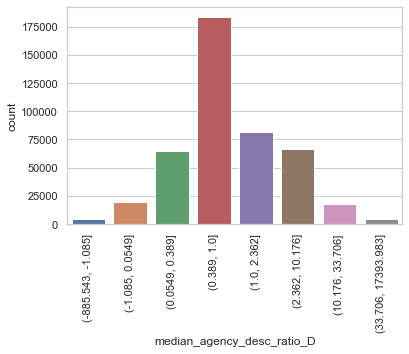

In [91]:
cut_percentiles('median_agency_desc_ratio',df3)

## 3.15 Feature 15: The ratio to average amount per description per month

In [92]:
# create average spending group by Cardholder Last Name and Merchant Category Code (MCC)
stat_by_agency = df.groupby(['Agency Name', 'Description','Month'])['Amount'].mean() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['mean_agency_desc_month']

df3 = pd.merge(df3, stat_by_agency, how='left', on=['Agency Name', 'Description','Month'])
# Feature 5: ratio of amount spending and avergae spending by merchant category 
df3['mean_agency_desc_month_ratio'] = np.where(df3['mean_agency_desc_month']==0,0, df3['Amount'] / df3['mean_agency_desc_month'])
df3['mean_agency_desc_month_ratio'].describe()

count    4.424580e+05
mean     9.991671e-01
std      9.916151e+13
min     -2.813624e+16
25%      1.707372e-01
50%      8.420043e-01
75%      1.000000e+00
max      2.813624e+16
Name: mean_agency_desc_month_ratio, dtype: float64

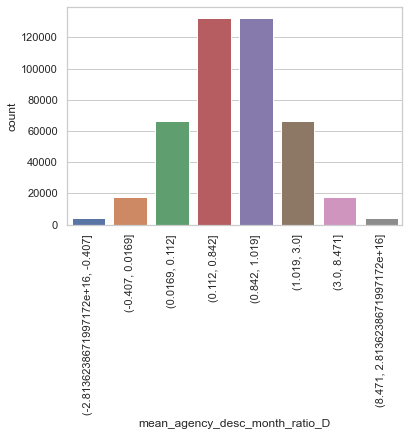

In [93]:
cut_percentiles('mean_agency_desc_month_ratio',df3)

## 3.16 Feature 16: The ratio to median amount per description per month

In [94]:
# create average spending group by Cardholder Last Name and Merchant Category Code (MCC)
stat_by_agency = df.groupby(['Agency Name', 'Description','Month'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['median_agency_desc_month']

df3 = pd.merge(df3, stat_by_agency, how='left', on=['Agency Name', 'Description','Month'])
# Feature 5: ratio of amount spending and avergae spending by merchant category 
df3['median_agency_desc_month_ratio'] = np.where(df3['median_agency_desc_month']==0,0, df3['Amount'] / df3['median_agency_desc_month'])
df3['median_agency_desc_month_ratio'].describe()

count    442458.000000
mean          2.896344
std          41.378888
min        -885.542169
25%           0.572710
50%           1.000000
75%           1.659998
max       19230.892626
Name: median_agency_desc_month_ratio, dtype: float64

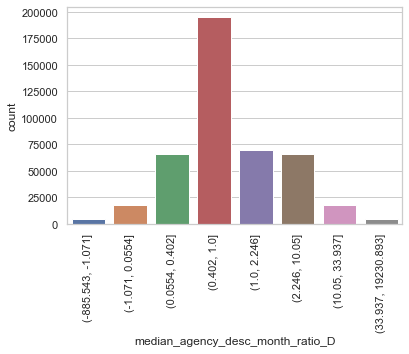

In [95]:
cut_percentiles('median_agency_desc_month_ratio',df3)

## 3.17 Feature 17: The process time for a transaction to realise

by subtracting posted date and transaction date we obtain the processing time for a transaction. we can identify a outliers based on a the pattern

In [100]:
df5['Process_time'] = (df3['Posted Date'] - df3['Transaction Date']).dt.days

In [101]:
df5['Process_time'].describe()

count    442458.000000
mean          1.876734
std           1.606127
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         183.000000
Name: Process_time, dtype: float64

In [102]:
df6 = df5.reset_index()

In [103]:
df7 = df6.groupby('Process_time')['index'].nunique()

In [104]:
df7 = df7.reset_index()

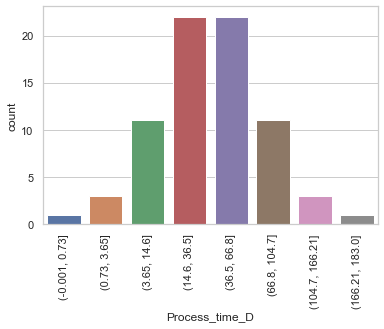

In [106]:
cut_percentiles("Process_time",df7)

In [107]:
df3.dtypes

Year-Month                          datetime64[ns]
Agency Number                                int64
Agency Name                                 object
Cardholder Last Name                        object
Cardholder First Initial                    object
                                         ...      
mean_agency_desc_month_ratio_D            category
median_agency_desc_month                   float64
median_agency_desc_month_ratio             float64
median_agency_desc_month_ratio_D          category
Process_time                                 int64
Length: 68, dtype: object

## 4. Conclusion
In total I created 17 more features that will help a model to better identify anomalies/outliers in the dataset. These can be leveraged to create model to detect outliers.
